In [1]:
from collections import deque
import random
import gym
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class WindyGridWorld(gym.Env):
    """
    A custom environment for the Windy GridWorld problem.

    Attributes:
        height (int): The height of the grid.
        width (int): The width of the grid.
        action_space (gym.spaces.Discrete): The action space of the environment (number of actions).
        observation_space (gym.spaces.Tuple): The observation space, representing grid coordinates (y, x).
        step_reward (float): The reward received for taking a step.
        end_reward (float): The reward received for reaching the goal state.
        start_state (tuple): The starting position of the agent (y, x).
        end_state (tuple): The goal position (y, x).
        crosswind (list): A list of wind strength for each column.
        current_state (tuple): The current position of the agent.
        moves (dict): A mapping of action indices to movement directions.

    Methods:
        step(action): Execute an action and return the next state, reward, and whether the episode is done.
        reset(seed=None, options=None): Reset the environment to the initial state.
        render(): Display the current state of the grid.
    """
    def __init__(self,
                 height=7,
                 width=10,
                 action_space=4,
                 step_reward=-1,
                 end_reward=1,
                 start_state=None,
                 end_state=None,
                 crosswind=None):
        """
        Initialize the Windy GridWorld environment.

        Args:
            height (int): The height of the grid. Default is 7.
            width (int): The width of the grid. Default is 10.
            action_space (int): The number of actions (up, down, right, left). Default is 4.
            step_reward (float): The reward for taking a step. Default is -1.
            end_reward (float): The reward for reaching the goal. Default is 1.
            start_state (tuple, optional): The starting position of the agent. Default is (3, 0).
            end_state (tuple, optional): The goal position. Default is (3, 7).
            crosswind (list, optional): The wind strength for each column. Default is [0, 0, 0, 1, 1, 1, 2, 2, 1, 0].
        """
        super(WindyGridWorld, self).__init__()

        if start_state is None:
            start_state = (3, 0)
        if end_state is None:
            end_state = (3, 7)
        if crosswind is None:
            crosswind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

        self.height = height
        self.width = width
        self.action_space = gym.spaces.Discrete(action_space)  # Action space: 4 actions (up, down, right, left).
        self.observation_space = gym.spaces.Tuple((
            gym.spaces.Discrete(height),
            gym.spaces.Discrete(width)
        ))  # Observation space: grid coordinates (y, x).
        self.step_reward = step_reward  # Reward for each step.
        self.end_reward = end_reward  # Reward for reaching the goal.
        self.start_state = start_state  # Starting position.
        self.end_state = end_state  # Goal position.
        self.current_state = self.start_state  # Initialize the current position to the start state.
        self.crosswind = crosswind  # Wind strength for each column.
        self.moves = {  # Mapping of actions to movements.
            0: (1, 0),  # Move up.
            1: (-1, 0),  # Move down.
            2: (0, 1),  # Move right.
            3: (0, -1),  # Move left.
        }

    def step(self, action):
        """
        Perform an action in the environment.

        Args:
            action (int): The action to take (0: up, 1: down, 2: right, 3: left).

        Returns:
            tuple: A tuple containing:
                - next_state (tuple): The agent's next state (y, x).
                - reward (float): The reward for taking the action.
                - done (bool): Whether the episode is finished.
        """
        # Get the movement vector for the given action.
        y, x = self.moves[action]

        # Update the agent's position based on the action.
        self.current_state = self.current_state[0] + y, self.current_state[1] + x

        # Clamp the agent's position within the grid boundaries.
        self.current_state = max(self.current_state[1], 0), max(self.current_state[0], 0)
        self.current_state = min(self.current_state[1], self.height - 1), min(self.current_state[0], self.width - 1)

        # Apply wind effect to the agent's position.
        crosswind_strength = self.crosswind[self.current_state[1]]
        self.current_state = self.current_state[0] + crosswind_strength, self.current_state[1]

        # Ensure the agent's position remains within the grid boundaries after wind effect.
        self.current_state = min(self.current_state[0], self.height - 1), self.current_state[1]

        # Check if the agent has reached the goal state.
        if self.current_state == self.end_state:
            return self.current_state, self.end_reward, True

        # Return the next state, step reward, and done flag.
        return self.current_state, self.step_reward, False

    def reset(self, seed=None, options=None):
        """
        Reset the environment to the initial state.

        Args:
            seed (int, optional): Random seed for reproducibility.
            options (dict, optional): Additional options for resetting.

        Returns:
            tuple: The initial state (y, x).
        """
        self.current_state = self.start_state  # Reset the agent's position to the start state.
        return self.current_state

    def render(self):
        """
        Render the current state of the environment.

        Displays a grid with the following symbols:
            - '.' represents an empty cell.
            - 'G' represents the goal state.
            - 'A' represents the agent's current position.
        """
        # Create an empty grid.
        grid = [['.' for _ in range(self.width)] for _ in range(self.height)]

        # Mark the goal position.
        grid[self.end_state[0]][self.end_state[1]] = 'G'

        # Mark the agent's current position.
        grid[self.current_state[0]][self.current_state[1]] = 'A'

        # Print the grid in reversed row order to align with standard grid visualization.
        print('\n'.join([''.join(row) for row in grid[::-1]]))
        print('\n')

In [3]:
class DeepQLearningNetwork(nn.Module):
    """
    A Deep Q-Learning Network (DQN) implemented using PyTorch.

    This network is used to approximate the Q-values for a given state and action in a reinforcement learning setting.

    Attributes:
        fx1 (nn.Linear): The first fully connected layer that maps the input state dimensions to the first hidden layer.
        fx2 (nn.Linear): The second fully connected layer that maps the first hidden layer to the second hidden layer.
        fx3 (nn.Linear): The final fully connected layer that maps the second hidden layer to the output action dimensions.

    Methods:
        forward(x): Performs a forward pass through the network to compute Q-values.
    """
    def __init__(self,
                 state_dims,
                 action_dims,
                 hidden1=256,
                 hidden2=512):
        """
        Initialize the Deep Q-Learning Network.

        Args:
            state_dims (int): The number of dimensions in the input state.
            action_dims (int): The number of possible actions (output dimensions).
            hidden1 (int): The number of neurons in the first hidden layer. Default is 256.
            hidden2 (int): The number of neurons in the second hidden layer. Default is 512.
        """
        super(DeepQLearningNetwork, self).__init__()

        # Fully connected layer from input state dimensions to the first hidden layer.
        self.fx1 = nn.Linear(state_dims, hidden1)

        # Fully connected layer from the first hidden layer to the second hidden layer.
        self.fx2 = nn.Linear(hidden1, hidden2)

        # Fully connected layer from the second hidden layer to the action dimensions.
        self.fx3 = nn.Linear(hidden2, action_dims)

    def forward(self, x):
        """
        Perform a forward pass through the network.

        Args:
            x (torch.Tensor): The input tensor representing the state, shape (batch_size, state_dims).

        Returns:
            torch.Tensor: The Q-values for each action, shape (batch_size, action_dims).
        """
        # Apply the first fully connected layer and ReLU activation.
        x = torch.relu(self.fx1(x))

        # Apply the second fully connected layer and ReLU activation.
        x = torch.relu(self.fx2(x))

        # Apply the final fully connected layer (no activation for raw Q-values).
        return self.fx3(x)


In [13]:
def train(episodes,
          gamma=0.9,
          epsilon_start=1.0,
          epsilon_end=0.01,
          epsilon_decay=0.99,
          batch_size=1024,
          learning_rate=1e-5,
          memory_size=10000,
          hidden1=128,
          hidden2=128,
          state_dims=2,
          action_dims=4):
    """
    Train a Deep Q-Learning Network (DQN) on the Windy GridWorld environment.

    Args:
        episodes (int): Number of training episodes.
        gamma (float): Discount factor for future rewards. Default is 0.9.
        epsilon_start (float): Initial exploration rate for epsilon-greedy policy. Default is 1.0.
        epsilon_end (float): Minimum exploration rate. Default is 0.01.
        epsilon_decay (float): Decay rate for epsilon. Default is 0.99.
        batch_size (int): Number of samples per training batch. Default is 1024.
        learning_rate (float): Learning rate for the optimizer. Default is 1e-5.
        memory_size (int): Maximum size of the replay buffer. Default is 10000.
        hidden1 (int): Number of neurons in the first hidden layer of the DQN. Default is 128.
        hidden2 (int): Number of neurons in the second hidden layer of the DQN. Default is 128.
        state_dims (int): Number of state dimensions. Default is 2.
        action_dims (int): Number of action dimensions. Default is 4.

    Returns:
        list: A record of total rewards for each episode.
    """
    # Select the appropriate device (CUDA, MPS, or CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

    # Initialize the environment and networks
    env = WindyGridWorld()
    policy_dqn = DeepQLearningNetwork(state_dims, action_dims, hidden1=hidden1, hidden2=hidden2).to(device)
    target_dqn = DeepQLearningNetwork(state_dims, action_dims, hidden1=hidden1, hidden2=hidden2).to(device)
    target_dqn.load_state_dict(policy_dqn.state_dict())  # Sync target network with policy network
    target_dqn.eval()  # Set target network to evaluation mode
    loss_fn = nn.MSELoss()  # Mean Squared Error loss function

    # Optimizer for updating the policy network
    optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=learning_rate)

    # Replay memory to store experiences
    memory = deque(maxlen=memory_size)
    epsilon = epsilon_start  # Initialize exploration rate
    total_reward_record = []  # To track rewards per episode

    # Training loop
    for episode in range(episodes):
        state = env.reset()  # Reset the environment for each episode
        total_reward = 0  # Track total reward for the episode
        loss = 0  # Initialize loss
        done = False  # Track whether the episode is finished

        while not done:
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()  # Random action (exploration)
            else:
                state_tensor = torch.tensor(state, dtype=torch.float).to(device)
                with torch.no_grad():
                    action = torch.argmax(policy_dqn(state_tensor)).item()  # Best action (exploitation)

            # Take the action and observe the next state and reward
            next_step = env.step(action)
            total_reward += next_step[1]  # Accumulate reward

            # Store the transition in replay memory
            memory.append((state, action, next_step[1], next_step[0], next_step[2]))

            # Update state and done flag
            state = next_step[0]
            done = next_step[2]

            # Training the policy network if memory is sufficient
            if len(memory) > batch_size:
                batch = random.sample(memory, batch_size)  # Sample a batch of experiences
                states, actions, rewards, next_states, dones = zip(*batch)

                # Convert batch data to tensors
                states = torch.tensor(states, dtype=torch.float).to(device)
                actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
                rewards = torch.tensor(rewards, dtype=torch.float).to(device)
                next_states = torch.tensor(next_states, dtype=torch.float).to(device)
                dones = torch.tensor(dones, dtype=torch.long).to(device)

                # Compute current Q-values using the policy network
                q_value = policy_dqn(states).gather(1, actions)

                # Compute target Q-values using the target network
                with torch.no_grad():
                    max_next_q_value = target_dqn(next_states).max(1)[0]
                    target_q_value = rewards + (gamma * max_next_q_value * (1 - dones))

                # Compute the loss between current and target Q-values
                loss = loss_fn(q_value.squeeze(), target_q_value)

                # Back propagate and update the policy network
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Decay epsilon for exploration-exploitation trade-off
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        # Update target network periodically
        if episode % 10 == 0:
            target_dqn.load_state_dict(policy_dqn.state_dict())

        # Record the total reward for the episode
        total_reward_record.append(total_reward)
        print(f'Episode: {episode + 1}, Total Reward: {total_reward}, Loss: {loss}')

    env.close()  # Close the environment
    return total_reward_record  # Return the reward record

In [26]:
def plot_total_rewards(total_reward_record):
    """
    Plot the total rewards over episodes.

    Args:
        total_reward_record (list): A list of total rewards for each episode.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(total_reward_record, label='Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards Over Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
total_reward_record = train(500)

Episode: 1, Total Reward: -70981, Loss: 4.790151137967769e-07
Episode: 2, Total Reward: -55310, Loss: 5.82031952944817e-06
Episode: 3, Total Reward: -26594, Loss: 1.5160391058088862e-06
Episode: 4, Total Reward: -29197, Loss: 4.017576316073246e-07
Episode: 5, Total Reward: -19610, Loss: 1.3161318292986834e-06
Episode: 6, Total Reward: -13628, Loss: 1.4755634083485347e-06
Episode: 7, Total Reward: -890, Loss: 2.2296553652267903e-06
Episode: 8, Total Reward: -22055, Loss: 8.224490102293203e-07
Episode: 9, Total Reward: -22298, Loss: 1.4866437823002343e-06
Episode: 10, Total Reward: -1039, Loss: 2.433285590086598e-05
Episode: 11, Total Reward: -2485, Loss: 0.00017571284843143076
Episode: 12, Total Reward: -15880, Loss: 3.6803350667469203e-05
Episode: 13, Total Reward: -20594, Loss: 4.951119535689941e-06
Episode: 14, Total Reward: -41460, Loss: 2.7515316105564125e-06
Episode: 15, Total Reward: -8319, Loss: 0.005509076174348593
Episode: 16, Total Reward: -2585, Loss: 1.4960163753130473e-05


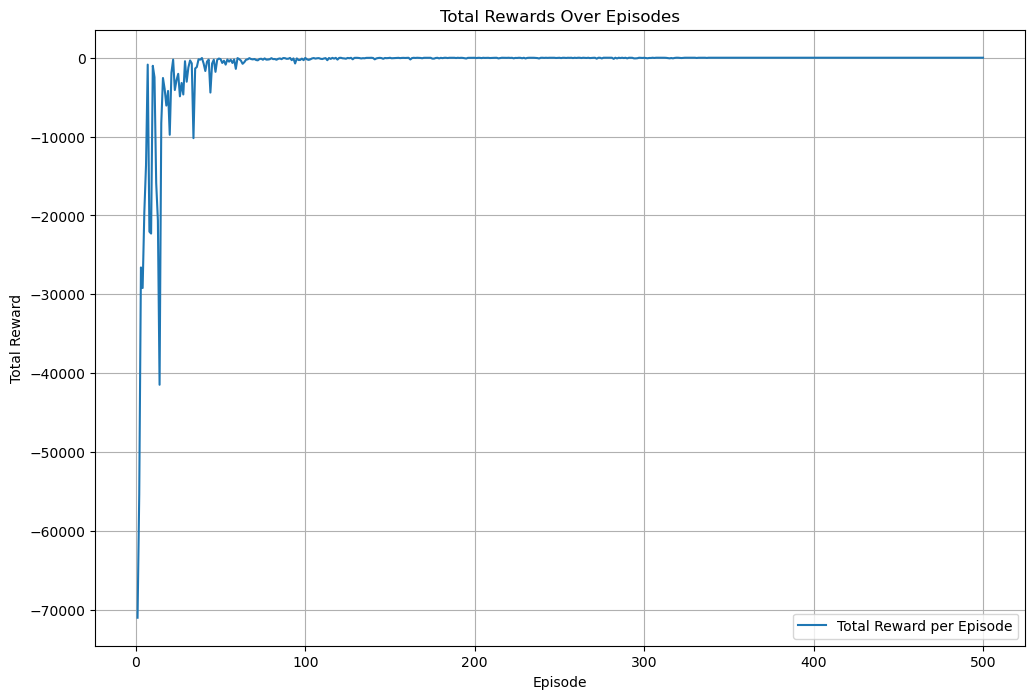

In [25]:
plot_total_rewards(total_reward_record)